In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

%matplotlib inline
import matplotlib.pyplot as plt

from PIL import Image
from matplotlib.pyplot import imshow
import matplotlib.cm as cm

import numpy as np

import skimage.transform
from scipy import ndimage
import scipy.misc

def image_show(image_path):
  imshow(np.asarray(Image.open(image_path, 'r')))
  plt.axis('off')
  plt.show()

import tensorflow as tf
flags = tf.app.flags
FLAGS = flags.FLAGS

#flags.DEFINE_string('model_dir', '/home/gezi/new/temp/image-caption/ai-challenger/model/showattentell.finetune/', '')
  
import sys, os, math
import gezi, melt
import numpy as np

from deepiu.util import algos_factory
from deepiu.seq2seq.rnn_decoder import SeqDecodeMethod

#debug
from deepiu.util import text2ids

TEXT_MAX_WORDS = 100    
decode_max_words = 20


from deepiu.util import ids2text
vocab_path = '/home/gezi/new/temp/image-caption/ai-challenger/tfrecord/seq-basic-finetune/vocab.txt'
ids2text.init(vocab_path)

image_dir = image_dir = '/home/gezi/data2/data/ai_challenger/image_caption/pic/'
image_file = '6275b5349168ac3fab6a493c509301d023cf39d3.jpg'
image_path = os.path.join(image_dir, image_file)
image_model_checkpoint_path = '/home/gezi/data/image_model_check_point/resnet_v2_152.ckpt'

#model_dir = '/home/gezi/new/temp/image-caption/ai-challenger/model.v4/showattentell.coverage'
model_dir = '/home/gezi/new/temp/image-caption/ai-challenger/model.v4/showattentell.coverage.resnet152.batch32/'
#model_dir = '/home/gezi/new/temp/image-caption/ai-challenger/model.v4/showattentell.coverage.fromimg.resnet152/'

FLAGS.model_dir = model_dir

image_model_name = melt.image.get_imagenet_from_checkpoint(image_model_checkpoint_path).name
FLAGS.image_model_name = image_model_name
if not melt.varname_in_checkpoint(image_model_name, model_dir):
  image_model = melt.image.ImageModel(image_model_checkpoint_path, feature_name='attention')
else:
  image_model = None
print('image_model', image_model)

import libpinyin
pinyin = libpinyin.Pinyin()
pinyin.Load('./data/pinyin/')

tensorflow_version: 1.4.0-rc1


INFO:tensorflow:Initializing vocabulary from file: /home/gezi/new/temp/image-caption/ai-challenger/tfrecord/seq-basic-finetune/vocab.txt
INFO:tensorflow:Created vocabulary with 10148 words
image_model None


ENCODE_UNK 1


In [2]:
if 'coverage' in model_dir:
  FLAGS.coverage_attention_wrapper = True

FLAGS.image_encoder = 'Rnn'
FLAGS.showtell_encode_scope = 'encode'
FLAGS.showtell_decode_scope = 'decode'
FLAGS.image_endpoint_feature_name = 'attention'
FLAGS.image_checkpoint_file = image_model_checkpoint_path 
FLAGS.pre_calc_image_feature = 1 
FLAGS.finetune_image_model = True 
FLAGS.image_features_batch_norm = True 
FLAGS.emb_dim = 512 
FLAGS.rnn_hidden_size = 512 
FLAGS.alignment_history = True

FLAGS.image_attention_size = FLAGS.image_attention_size or melt.image.get_num_features(FLAGS.image_model_name)
FLAGS.image_feature_len = FLAGS.image_feature_len or melt.image.get_feature_dim(FLAGS.image_model_name) * FLAGS.image_attention_size

beam_size = 10
length_normalization_factor = 0.25

In [3]:
algo = 'show_and_tell'
global_scope = algo
main_scope = 'main'
melt.apps.image_processing.init()
with tf.variable_scope(global_scope):
  with tf.variable_scope(main_scope):
    predictor =  algos_factory.gen_predictor(algo)
    predictor.init_predict_text(decode_method=SeqDecodeMethod.ingraph_beam, 
                                beam_size=beam_size,
                                length_normalization_factor=length_normalization_factor,
                                logprobs_history=True,
                                alignment_history=True)  

predictor.load(FLAGS.model_dir) 

cell: <class 'tensorflow.python.ops.rnn_cell_impl.BasicLSTMCell'>
cell: <class 'tensorflow.python.ops.rnn_cell_impl.BasicLSTMCell'>
rnn decoder gen only mode
use melt.seq2seq.CoverageBahdanauAttention


INFO:tensorflow:Restoring parameters from /home/gezi/new/temp/image-caption/ai-challenger/model.v4/showattentell.coverage.fromimg.resnet152/model.ckpt-2.10-69000


restore ok: /home/gezi/new/temp/image-caption/ai-challenger/model.v4/showattentell.coverage.fromimg.resnet152/model.ckpt-2.10-69000
load model ok /home/gezi/new/temp/image-caption/ai-challenger/model.v4/showattentell.coverage.fromimg.resnet152/model.ckpt-2.10-69000 duration: 2.67607402802


In [4]:
def simple_predict(image_path, predictor):
  timer = gezi.Timer('beam search using time')
  img = melt.read_image(image_path)
  if image_model:
    #attention model gen features only
    feature = image_model.gen_features(img) if image_model is not None else img
  else:
    feature = [img]    
  #texts_list, scores_list = predictor.predict_text(feature)
  #timer.print()
  logprobs_history = None 
  alignment_history = None

  l = predictor.predict_text(feature)
  timer.print()
  texts_list, scores_list= l[0], l[1]
  try:
    logprobs_history = l[2]
    alignment_history = l[3]
  except Exception:
    pass

  #print(alignment_history)

  texts = texts_list[0]
  scores = scores_list[0]
  if logprobs_history is not None:
    logprobs = logprobs_history[0]
  else:
    logprobs = [None] * len(texts)
  if alignment_history is not None:
    alignments = alignment_history[0]
  else:
    alignments = [None] * len(texts)
    
  logprob = None 
  alignment = None 
    
  for text, score, logprob, alignment in zip(texts, scores, logprobs, alignments):
    print('align shape', alignment.shape)
    print(ids2text.ids2text(text), score)
    print(text, len(text))
    if logprob is not None:
      print(map(math.exp, logprob))
    #if alignment is not None:
    #  print(alignment)
    #  print(alignment[10], alignment[11], alignment[12])


In [5]:
#simple_predict(image_path, predictor)

In [6]:
def predict(image_path, predictor, length_normalization_factor=0.25, num_show=1):
  img = melt.read_image(image_path)
  if image_model:
    feature = image_model.gen_feature(img) if image_model is not None else img
  else:
    feature = [img]

  timer = gezi.Timer()
  texts, scores, logprobs_history, alignment_history = predictor.predict_text(feature)
  for i, (text, score, logprob, alignment) in enumerate(zip(texts[0], scores[0], logprobs_history[0], alignment_history[0])):
    print(ids2text.ids2text(text), score)

    # Plot images with attention weights
    words = ids2text.ids2words(text) 
    img = ndimage.imread(image_path)
    
    num_features = melt.image.get_num_features(image_model_name)
    dim = int(np.sqrt(num_features))
    #print('dim:', dim)

    n_words = len(words)
    n_words += 1 #for ori image
    w = np.round(np.sqrt(n_words))
    h = np.ceil(np.float32(n_words) / w)
    
    #print(n_words, w, h)
            
    plt.subplot(w, h, 1)
    plt.imshow(img)
    plt.axis('off')

    #img = scipy.misc.imresize(img, (dim, dim))  

    #smooth = True  #TODO smooth = Ture seems not work not back ground pic
    smooth = False
    if i < 3:  
      print('probs', [math.exp(x) for x in logprob])
      for j in range(len(words)):
        #if i == 0:
        #  print(i, j, words[j], alignment[j])
        plt.subplot(w, h, j + 2)
        lab = pinyin.Convert(words[j].decode('utf8').encode('gbk'))
        lab += '(%0.2f)'%math.exp(logprob[j])
        plt.text(0, 1, lab, backgroundcolor='white', fontsize=10)
        plt.text(0, 1, lab, color='black', fontsize=10)
        plt.imshow(img)
        if smooth:
          alpha_img = skimage.transform.pyramid_expand(alignment[j].reshape(dim, dim), upscale=16, sigma=20)
        else:
          alpha_img = skimage.transform.resize(alignment[j].reshape(dim, dim), [img.shape[0], img.shape[1]])
        plt.imshow(alpha_img, alpha=0.8)
        plt.set_cmap(cm.Greys_r)
        plt.axis('off')
      plt.show()
      #plt.savefig('test%d.pdf'%i)

    print('beam search using time(ms):', timer.elapsed_ms())

In [7]:
%%html
<style>
.output_wrapper, .output {
    height:auto !important;
    max-height:10000px;  /* your desired max-height here */
}
.output_scroll {
    box-shadow:none !important;
    webkit-box-shadow:none !important;
}
</style>

image_name like 6275b5349168ac3fab6a493c509301d023cf39d3.jpg: 743e12038dcf7dbc68123ca7dff9d6d66eb09ea1


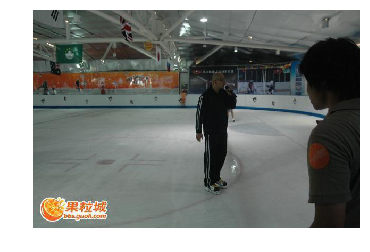

INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.


checkpoint /home/gezi/data/image_model_check_point/resnet_v2_152.ckpt model_name resnet_v2_152 height 224 width 224
build graph for final one feature
preprocessing_fn net_name inception_resnet_v2 height 224 width 224


INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.


image_model will get feature_name Conv2d_7b_1x1
image_feature: Tensor("Flatten/flatten/Reshape:0", shape=(?, 38400), dtype=float32)
build graph for attention features
preprocessing_fn net_name inception_resnet_v2 height 224 width 224
image_model will get feature_name Conv2d_7b_1x1
image_feature: Tensor("Flatten_1/flatten/Reshape:0", shape=(?, 38400), dtype=float32)


ValueError: No variables to save

In [8]:
while True:
  image_name = raw_input('image_name like 6275b5349168ac3fab6a493c509301d023cf39d3.jpg: ')
  image_name = image_name.strip().replace('file://', '')
  if image_name == 'q':
    break
  if not image_name.endswith('.jpg'):
    image_name += '.jpg'

  image_path = os.path.join(image_dir, image_name)

  if not os.path.exists(image_path):
    print('path not exists:%s'%image_path)
    image_path = image_name
    if not os.path.exists(image_path):
        continue
  plt.subplot(1, 1, 1)
  image_show(image_path)
  predict(image_path, predictor)
  #predict(image_path, predictor2, gen_feature=False)

In [ ]:
import glob 
for img in glob.glob('/home/gezi/new2/data/ai_challenger/image_caption/test_pic/*.jpg'):
    image_show(img)
    predict(img, predictor)